# Traffic Crash Injury Prediction: End-to-End ML Pipeline
# Project by: Eden Misan and Hadar Yakir
### Project Overview: This project aims to predict whether a traffic crash in Chicago results in an injury using various environmental and crash-related features. We implement a full classification pipeline and perform unsupervised clustering to identify patterns in crash data.

## Environment Setup and Library Imports

In [1]:
### CODE BY GPT ###
!pip install -r requirements.txt
# =========================
# Core
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Scikit-learn – preprocessing
# =========================
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# =========================
# Scikit-learn – model selection
# =========================
from sklearn.model_selection import train_test_split

# =========================
# Scikit-learn – models
# =========================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# =========================
# Scikit-learn – evaluation metrics
# =========================
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    average_precision_score)
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score)
from sklearn.decomposition import PCA


# =========================
# GPU (RAPIDS – optional)
# =========================
USE_GPU = True
try:
    import cudf
    from cuml.svm import SVC as cuSVC
    from cuml.metrics import roc_auc_score as cuml_roc_auc_score
except Exception as e:
    USE_GPU = False
    gpu_import_error = repr(e)

  Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)


ERROR: Ignored the following versions that require a different python version: 8.2.0 Requires-Python >=3.10; 8.2.1 Requires-Python >=3.10; 8.2.2 Requires-Python >=3.10; 8.3.0 Requires-Python >=3.10; 8.3.1 Requires-Python >=3.10
ERROR: Could not find a version that satisfies the requirement click==8.2.1 (from versions: 0.1, 0.2, 0.3, 0.4, 0.5, 0.5.1, 0.6, 0.7, 1.0, 1.1, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 3.0, 3.1, 3.2, 3.3, 4.0, 4.1, 5.0, 5.1, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7.dev0, 6.7, 7.0, 7.1, 7.1.1, 7.1.2, 8.0.0a1, 8.0.0rc1, 8.0.0, 8.0.1, 8.0.2, 8.0.3, 8.0.4, 8.1.0, 8.1.1, 8.1.2, 8.1.3, 8.1.4, 8.1.5, 8.1.6, 8.1.7, 8.1.8)
ERROR: No matching distribution found for click==8.2.1
C:\Users\hadar\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\hadar\anaconda3\lib\site-packages\pandas\cor

## Data Acquisition and Exploration 
### In this section, we load the cleaned dataset. The data includes features such as weather conditions, lighting, speed limits, and contributory causes of the accidents.

In [2]:
file_path = "Traffic_Crashes_-_Crashes.txt"
df = pd.read_csv(file_path)

## Target Variable Definition

In [3]:
### CODE BY GPT ###
# יצירת משתנה יעד בינארי: פגיעה / ללא פגיעה
df['INJURY'] = df['MOST_SEVERE_INJURY'].apply(
    lambda x: 0 if x == 'NO INDICATION OF INJURY' else 1
).astype(int)

# הסרת עמודת המקור
df = df.drop(columns=['MOST_SEVERE_INJURY'])

C:\Users\hadar\AppData\Local\Temp\ipykernel_44084\2186032887.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='INJURY', data=df, palette='viridis')


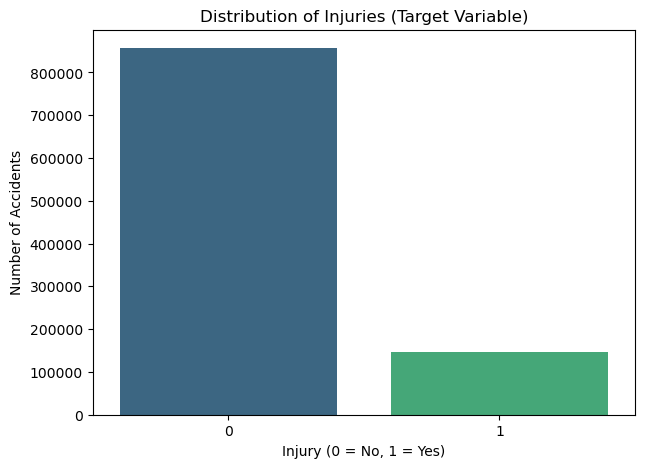

Class Percentages:
INJURY
0    85.474903
1    14.525097
Name: proportion, dtype: float64


In [4]:
### CODE BY GPT ###
# 1. Distribution of the Target Variable (INJURY)
plt.figure(figsize=(7, 5))
sns.countplot(x='INJURY', data=df, palette='viridis')
plt.title('Distribution of Injuries (Target Variable)')
plt.xlabel('Injury (0 = No, 1 = Yes)')
plt.ylabel('Number of Accidents')
plt.show()
print("Class Percentages:")
print(df['INJURY'].value_counts(normalize=True) * 100)

## Data Preprocessing

## Feature Removal

### Columns that do not contribute meaningful predictive information were removed from the dataset. These include unique identifiers, administrative and reporting fields, detailed injury breakdowns derived from the target variable, location-specific attributes, and variables with limited relevance to injury prediction. Removing these columns helps reduce noise, prevent data leakage, and improve model interpretability and performance.


In [5]:
### CODE BY GPT ###
# רשימת עמודות למחיקה
columns_to_drop = [
    'CRASH_RECORD_ID',
    'CRASH_DATE_EST_I',
    'LANE_CNT',
    'REPORT_TYPE',
    'INTERSECTION_RELATED_I',
    'NOT_RIGHT_OF_WAY_I',
    'HIT_AND_RUN_I',
    'DOORING_I',
    'PHOTOS_TAKEN_I',
    'STATEMENTS_TAKEN_I',
    'WORK_ZONE_I',
    'WORK_ZONE_TYPE',
    'WORKERS_PRESENT_I',
    'DATE_POLICE_NOTIFIED',
    'SEC_CONTRIBUTORY_CAUSE',
    'STREET_DIRECTION',
    'STREET_NO',
    'STREET_NAME',
    'BEAT_OF_OCCURRENCE',
    'INJURIES_TOTAL',
    'INJURIES_FATAL',
    'INJURIES_INCAPACITATING',
    'INJURIES_NON_INCAPACITATING',
    'INJURIES_REPORTED_NOT_EVIDENT',
    'INJURIES_NO_INDICATION',
    'INJURIES_UNKNOWN',
    'LOCATION',
    'LATITUDE',
    'LONGITUDE',
    'CRASH_TYPE'
]

# מחיקת העמודות
df = df.drop(columns=columns_to_drop)

In [6]:
### CODE BY GPT ###
# המרת עמודת התאריך לפורמט datetime
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'])

# יצירת עמודת זמן (שעה בלבד)
df['CRASH_TIME'] = df['CRASH_DATE'].dt.time

# יצירת עמודת חודש
df['CRASH_MONTH'] = df['CRASH_DATE'].dt.month

# יצירת עמודת שנה
df['CRASH_YEAR'] = df['CRASH_DATE'].dt.year

# יצירת עמודת יום בשבוע
# Sunday=1 ... Saturday=7
df['CRASH_DAY_OF_WEEK'] = df['CRASH_DATE'].dt.weekday
df['CRASH_DAY_OF_WEEK'] = ((df['CRASH_DAY_OF_WEEK'] + 1) % 7) + 1
df = df[df['CRASH_YEAR'] == 2025].copy()
df = df.drop(columns=['CRASH_DATE','CRASH_YEAR'])

In [7]:
### CODE BY GPT ###
# 1. המרת העמודה לפורמט זמן 
temp_dt = pd.to_datetime(df['CRASH_TIME'].astype(str))

# 2. עיגול לשעה הקרובה ביותר (H מייצג Hour)
# הפונקציה הזו מעגלת למעלה אם עברו 30 דקות ומעלה
df['CRASH_HOUR'] = temp_dt.dt.round('H').dt.hour

C:\Users\hadar\AppData\Local\Temp\ipykernel_44084\2244635356.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_dt = pd.to_datetime(df['CRASH_TIME'].astype(str))
C:\Users\hadar\AppData\Local\Temp\ipykernel_44084\2244635356.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['CRASH_HOUR'] = temp_dt.dt.round('H').dt.hour


## Exploratory Data Analysis
### Before modeling, we visualize key features to understand their distribution and relationship with injuries. This helps us identify trends such as high-risk hours.

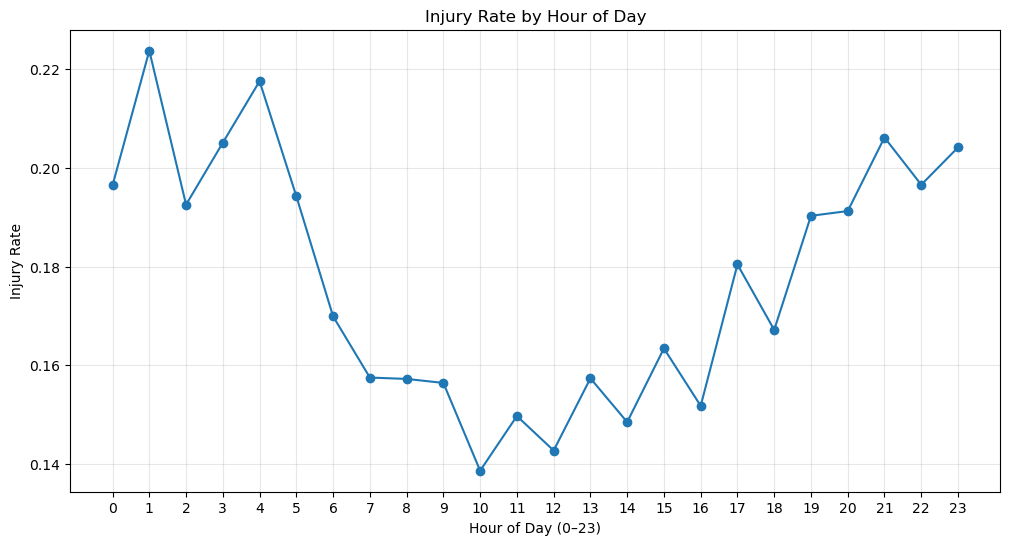

In [8]:
### CODE BY GPT ###
# טבלה לפי שעה
hourly = (
    df.groupby("CRASH_HOUR")["INJURY"]
      .agg(["count", "sum"])
      .rename(columns={"count": "total", "sum": "injuries"})
)

hourly["injury_rate"] = hourly["injuries"] / hourly["total"]

plt.figure(figsize=(12,6))
plt.plot(hourly.index, hourly["injury_rate"], marker="o")
plt.title("Injury Rate by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Injury Rate")
plt.xticks(range(0,24))
plt.grid(alpha=0.3)
plt.show()


### This figure shows the injury rate by hour of day, representing the proportion of crashes that resulted in an injury at each hour. The injury rate is higher during late-night and early-morning hours, indicating that crashes occurring at these times are more likely to result in injuries. In contrast, lower injury rates are observed during late morning and early afternoon hours, despite a higher volume of crashes. The injury rate increases again in the evening, suggesting that temporal factors play an important role in crash severity and justify the inclusion of time-based features in the predictive models.

In [9]:
### CODE BY GPT ###
crash_time = pd.to_datetime(df['CRASH_TIME'].astype(str), format='%H:%M:%S', errors='coerce')

# דקות מאז חצות (שומר דיוק: שעה+דקות+שניות)
df['CRASH_MINUTES_FROM_MIDNIGHT'] = crash_time.dt.hour * 60 + crash_time.dt.minute + (crash_time.dt.second / 60)

# IS_NIGHT: בין 20:00–06:00
# 20:00 = 1200 דקות, 06:00 = 360 דקות
df['IS_NIGHT'] = df['CRASH_MINUTES_FROM_MIDNIGHT'].apply(
    lambda m: 1 if (m >= 1200 or m < 360) else 0)

# IS_WEEKEND: יום ראשון (1) או שבת (7)
df['IS_WEEKEND'] = df['CRASH_DAY_OF_WEEK'].apply(lambda d: 1 if d in [1, 7] else 0)

# IS_RUSH_HOUR: 7–9 כולל ו־16–18 כולל
df['IS_RUSH_HOUR'] = df['CRASH_MINUTES_FROM_MIDNIGHT'].apply(
    lambda m: 1 if (420 <= m <= 540 or 960 <= m <= 1080) else 0)

df = df.drop(columns=['CRASH_MINUTES_FROM_MIDNIGHT'])

### The column `CRASH_MINUTES_FROM_MIDNIGHT` was used to derive additional time-related features that provide more informative representations of crash timing. After generating these features, the original column was removed from the dataset due to its high correlation with the crash hour variable, in order to avoid redundancy and multicollinearity.


In [10]:
### CODE BY GPT ###
# המהירות החוקית הנמוכה ביותר בשיקגו היא 15 mph (סמטאות),
# לכן ערכים נמוכים מ-15 אינם מייצגים תמרור חוקי ונחשבים שגויים
df['POSTED_SPEED_LIMIT'] = pd.to_numeric(df['POSTED_SPEED_LIMIT'], errors='coerce')

# להשאיר רק שורות עם מהירות >= 15 או ערך חסר (NaN)
df = df[df['POSTED_SPEED_LIMIT'].isna() | (df['POSTED_SPEED_LIMIT'] >= 15)].copy()

In [11]:
### CODE BY GPT ###
col = 'TRAFFIC_CONTROL_DEVICE'
threshold = 5000

# 1) איחוד UNKNOWN ו-NaN ל-OTHER
df[col] = df[col].fillna('OTHER').replace('UNKNOWN', 'OTHER')

KEEP = {
    "NO CONTROLS",
    "TRAFFIC SIGNAL",
    "STOP SIGN/FLASHER"}
df = df[df["TRAFFIC_CONTROL_DEVICE"].isin(KEEP)].copy()

df = df[df[col] != 'OTHER'].copy()

In [12]:
### CODE BY GPT ###
col = 'DEVICE_CONDITION'

# ניקוי רווחים ויישור טקסט
df[col] = df[col].astype(str).str.strip()

# 1) איחוד UNKNOWN עם OTHER (וגם NaN אם יש)
df[col] = df[col].replace({'UNKNOWN': 'OTHER'}).fillna('OTHER')

# 2) איחוד קטגוריות "לא מתפקד" לקטגוריה אחת
df[col] = df[col].replace({
    'FUNCTIONING IMPROPERLY': 'NOT_FUNCTIONING',
    'NOT FUNCTIONING': 'NOT_FUNCTIONING',
    'WORN REFLECTIVE MATERIAL': 'NOT_FUNCTIONING',
    'MISSING': 'NOT_FUNCTIONING'
})

# 3) הסרת שורות עם OTHER (כולל UNKNOWN שאוחד)
df = df[df[col] != 'OTHER'].copy()

In [13]:
### CODE BY GPT ###
col = 'WEATHER_CONDITION'

# 1) ניקוי רווחים
df[col] = df[col].astype(str).str.strip()

# 2) הסרת UNKNOWN / OTHER / NaN
df[col] = df[col].replace(['UNKNOWN', 'OTHER'], 'UNKNOWN').fillna('UNKNOWN')
df = df[df[col] != 'UNKNOWN'].copy()

# 3) איחוד קטגוריות בתוך אותה עמודה
df.loc[df[col] == 'CLEAR', col] = 'Clear'
df.loc[df[col] == 'CLOUDY/OVERCAST', col] = 'Cloudy'
df.loc[df[col] == 'RAIN', col] = 'Rain'

df.loc[df[col].isin([
    'SNOW',
    'SLEET/HAIL',
    'FREEZING RAIN/DRIZZLE',
    'BLOWING SNOW'
]), col] = 'Snow/Ice'

df.loc[df[col].isin([
    'FOG/SMOKE/HAZE',
    'SEVERE CROSS WIND GATE',
    'BLOWING SAND, SOIL, DIRT'
]), col] = 'Low Visibility'

In [14]:
### CODE BY GPT ###
# ניקוי רווחים
df['LIGHTING_CONDITION'] = df['LIGHTING_CONDITION'].astype(str).str.strip()

# הסרת UNKNOWN
df = df[df['LIGHTING_CONDITION'] != 'UNKNOWN'].copy()

# איחוד קטגוריות: DAWN + DUSK -> TWILIGHT
df['LIGHTING_CONDITION'] = df['LIGHTING_CONDITION'].replace({
    'DAWN': 'TWILIGHT',
    'DUSK': 'TWILIGHT'})

In [15]:
### CODE BY GPT ###
df = df[~df['TRAFFICWAY_TYPE'].isin([
    'OTHER',
    'UNKNOWN',
    'NOT REPORTED',
    'UNKNOWN INTERSECTION TYPE'
])].copy()
df = df[~df['ROADWAY_SURFACE_COND'].isin(['OTHER', 'UNKNOWN'])].copy()

In [16]:
### CODE BY GPT ###
col = 'ROAD_DEFECT'

# 1) ניקוי רווחים
df[col] = df[col].astype(str).str.strip()

# 2) הסרת UNKNOWN ו-OTHER
df = df[~df[col].isin(['UNKNOWN', 'OTHER'])].copy()

# 3) המרה לבינארי:
# NO DEFECTS -> 0
# כל סוג פגם אחר -> 1
df[col] = df[col].apply(
    lambda x: 0 if x == 'NO DEFECTS' else 1).astype(int)

In [17]:
### CODE BY GPT ###
df = df[~df['PRIM_CONTRIBUTORY_CAUSE'].isin([
    'UNABLE TO DETERMINE',
    'NOT APPLICABLE'])].copy()

In [18]:
### CODE BY GPT ###
df['CRASH_TIME'] = pd.to_datetime(df['CRASH_TIME'], format='%H:%M:%S')

# דקות מאז חצות
df['CRASH_MINUTES_FROM_MIDNIGHT'] = (
    df['CRASH_TIME'].dt.hour * 60 +
    df['CRASH_TIME'].dt.minute)
df = df.drop(columns=['CRASH_TIME'])

In [19]:
### CODE BY GPT ###
df['CRASH_TIME_SIN'] = np.sin(2 * np.pi * df['CRASH_MINUTES_FROM_MIDNIGHT'] / 1440)
df['CRASH_TIME_COS'] = np.cos(2 * np.pi * df['CRASH_MINUTES_FROM_MIDNIGHT'] / 1440)
df = df.drop(columns=['CRASH_MINUTES_FROM_MIDNIGHT'])

In [20]:
### CODE BY GPT ###
# ------------------------------------------------------------
# 0) עזר: לנקות טקסטים בעמודות קטגוריות (מונע רווחים/None)
# ------------------------------------------------------------
cat_cols_for_rules = [
    'TRAFFIC_CONTROL_DEVICE',
    'LIGHTING_CONDITION',
    'WEATHER_CONDITION'
]

for c in cat_cols_for_rules:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

# ------------------------------------------------------------
# 1) NIGHT + NO TRAFFIC CONTROL
#    (IS_NIGHT = 1 וגם TRAFFIC_CONTROL_DEVICE == 'NO CONTROLS')
# ------------------------------------------------------------
df['NIGHT_AND_NO_CONTROL'] = (
    (df['IS_NIGHT'] == 1) &
    (df['TRAFFIC_CONTROL_DEVICE'].eq('NO CONTROLS'))
).astype(int)

# בלילה בלי בקרה תנועתית יש פחות "הכוונה" → עלול להגדיל פגיעות.

# ------------------------------------------------------------
# 2) NIGHT + POOR LIGHTING
#    (לילה + DARKNESS)
# ------------------------------------------------------------
df['NIGHT_AND_POOR_LIGHTING'] = (
    (df['IS_NIGHT'] == 1) &
    (df['LIGHTING_CONDITION'].eq('DARKNESS'))
).astype(int)

# שילוב חושך ותאורה לקויה מצמצם ראות וזמן תגובה.

# ------------------------------------------------------------
# 3) RUSH HOUR + NO TRAFFIC CONTROL
# ------------------------------------------------------------
df['RUSH_AND_NO_CONTROL'] = (
    (df['IS_RUSH_HOUR'] == 1) &
    (df['TRAFFIC_CONTROL_DEVICE'].eq('NO CONTROLS'))
).astype(int)

# עומס תנועה ללא ויסות מעלה קונפליקטים וסיכון לתאונות.

# ------------------------------------------------------------
# 4) WEEKEND + NIGHT
# ------------------------------------------------------------
df['WEEKEND_NIGHT'] = (
    (df['IS_WEEKEND'] == 1) &
    (df['IS_NIGHT'] == 1)
).astype(int)

# שעות בילוי/עייפות בסופ"ש בלילה קשורות לעיתים לסיכון מוגבר.

# ------------------------------------------------------------
# 5) MULTI_VEHICLE (יותר מרכב אחד)
# ------------------------------------------------------------
if 'NUM_UNITS' in df.columns:
    df['MULTI_VEHICLE_3PLUS'] = (df['NUM_UNITS'] >= 3).astype(int)

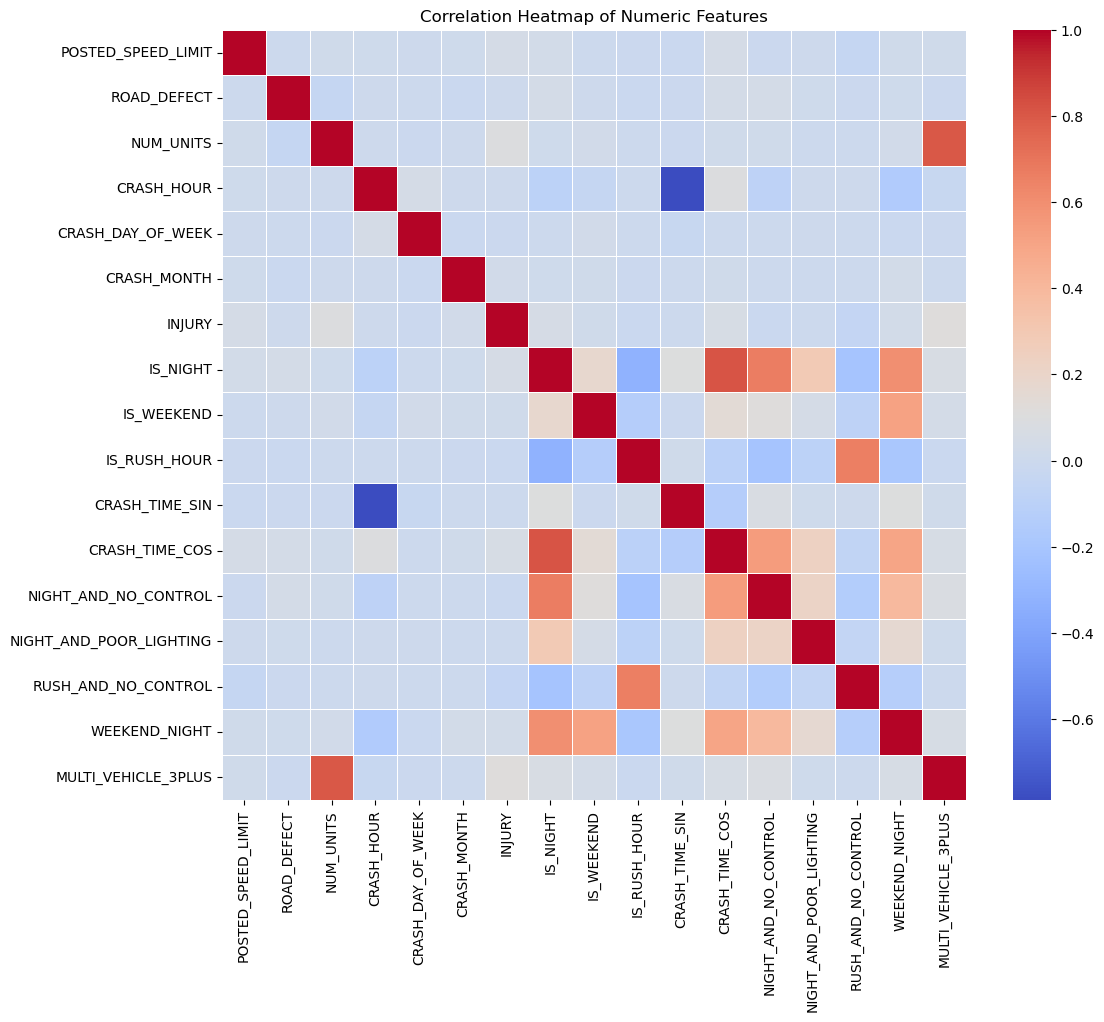

In [21]:
### CODE BY GPT ###
# מפת חום של קורלציות (למשתנים נומריים בלבד)
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

### This correlation heatmap shows the relationships between key numerical and engineered features. Most features exhibit weak to moderate correlations, indicating limited redundancy. As expected, time-related and interaction features are more strongly correlated with each other, while no single feature shows a strong linear correlation with the injury outcome, highlighting the need for non-linear models and feature combinations.

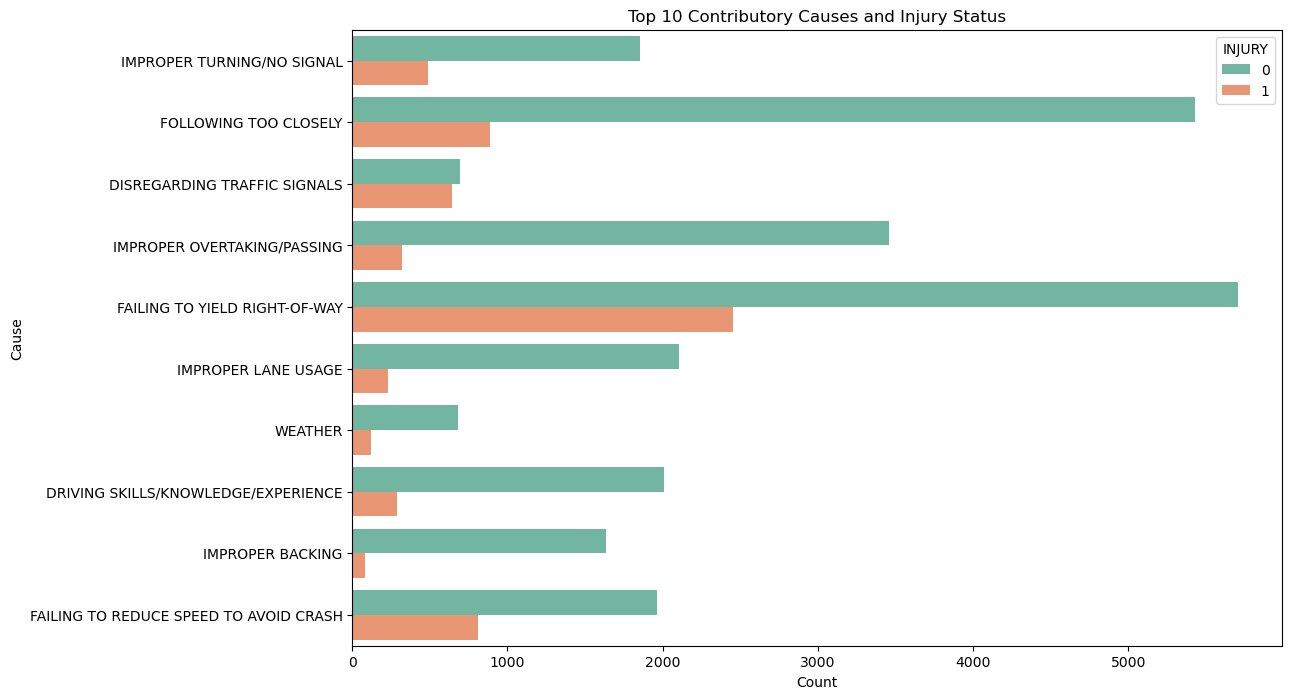

In [22]:
### CODE BY GPT ###
# 10 הגורמים המובילים לתאונות והקשר שלהם לפציעה
plt.figure(figsize=(12, 8))
top_causes = df['PRIM_CONTRIBUTORY_CAUSE'].value_counts().nlargest(10).index
sns.countplot(y='PRIM_CONTRIBUTORY_CAUSE', hue='INJURY', data=df[df['PRIM_CONTRIBUTORY_CAUSE'].isin(top_causes)], palette='Set2')
plt.title('Top 10 Contributory Causes and Injury Status')
plt.xlabel('Count')
plt.ylabel('Cause')
plt.show()

### This bar chart shows the top contributing crash causes, separated by injury and non-injury outcomes. Certain causes, such as failing to yield right-of-way and following too closely, are associated with a higher number of injury-related crashes, indicating that driver behavior plays a significant role in crash severity.

## Train–Test Split

In [23]:
### CODE BY GPT ###
y = df['INJURY']
X = df.drop(columns=['INJURY'])

# Train (60%), Val (20%), Test (20%)
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp)

X_train = X_train.copy()
X_val   = X_val.copy()
X_test  = X_test.copy()

## Encoding and Feature Scaling

In [24]:
### CODE BY GPT ###
# =========================
# OHE (fit on TRAIN, transform on VAL/TEST)
# =========================
ohe_cols = [
    'TRAFFIC_CONTROL_DEVICE',
    'DEVICE_CONDITION',
    'WEATHER_CONDITION',
    'LIGHTING_CONDITION',
    'FIRST_CRASH_TYPE',
    'TRAFFICWAY_TYPE',
    'ALIGNMENT',
    'ROADWAY_SURFACE_COND',
    'DAMAGE',
    'PRIM_CONTRIBUTORY_CAUSE'
]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

train_ohe = ohe.fit_transform(X_train[ohe_cols])
val_ohe   = ohe.transform(X_val[ohe_cols])
test_ohe  = ohe.transform(X_test[ohe_cols])

new_cols = ohe.get_feature_names_out(ohe_cols)

train_ohe_df = pd.DataFrame(train_ohe, columns=new_cols, index=X_train.index).astype(int)
val_ohe_df   = pd.DataFrame(val_ohe,   columns=new_cols, index=X_val.index).astype(int)
test_ohe_df  = pd.DataFrame(test_ohe,  columns=new_cols, index=X_test.index).astype(int)

X_train = pd.concat([X_train.drop(columns=ohe_cols), train_ohe_df], axis=1)
X_val   = pd.concat([X_val.drop(columns=ohe_cols),   val_ohe_df],   axis=1)
X_test  = pd.concat([X_test.drop(columns=ohe_cols),  test_ohe_df],  axis=1)

# =========================
# Scaling (fit on TRAIN, transform on VAL/TEST)
# =========================
num_cols = [
    'POSTED_SPEED_LIMIT',
    'NUM_UNITS',
    'CRASH_TIME_SIN',
    'CRASH_TIME_COS',
]

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols]   = scaler.transform(X_val[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

In [25]:
print(y.value_counts(normalize=True))

INJURY
0    0.790229
1    0.209771
Name: proportion, dtype: float64


## Supervised Learning: Injury Classification

In [26]:
### CODE BY GPT ###
# ============================================================
# Random Forest - Maximize F2 (tune on VAL, eval on TEST)
# ============================================================

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=10,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

proba_val  = rf.predict_proba(X_val)[:, 1]
proba_test = rf.predict_proba(X_test)[:, 1]
proba_test_rf = proba_test

beta = 2
prec, rec, thr = precision_recall_curve(y_val, proba_val)

best_f2 = -1
best_thr = None

for i in range(len(thr)):
    t = thr[i]
    y_pred_val = (proba_val >= t).astype(int)
    f2_val = fbeta_score(y_val, y_pred_val, beta=beta, zero_division=0)
    if f2_val > best_f2:
        best_f2 = f2_val
        best_thr = t
rf_best_threshold = best_thr
y_pred_test = (proba_test >= best_thr).astype(int)

y_pred_val_best = (proba_val >= best_thr).astype(int)

p_val  = precision_score(y_val, y_pred_val_best, zero_division=0)
r_val  = recall_score(y_val, y_pred_val_best, zero_division=0)
f2_val = fbeta_score(y_val, y_pred_val_best, beta=beta, zero_division=0)

p_test  = precision_score(y_test, y_pred_test, zero_division=0)
r_test  = recall_score(y_test, y_pred_test, zero_division=0)
f2_test = fbeta_score(y_test, y_pred_test, beta=beta, zero_division=0)

roc_auc_test = roc_auc_score(y_test, proba_test)
pr_auc_test  = average_precision_score(y_test, proba_test)

print("======================================================")
print("MODEL: Random Forest (Tune on VAL, eval on TEST)")
print(f"Rule: maximize F{beta} on VAL (no minimum recall constraint)")
print("======================================================")
print(f"Chosen threshold (from VAL): {best_thr:.6f}")
print(f"VAL  Precision: {p_val:.3f} | VAL  Recall: {r_val:.3f} | VAL  F{beta}: {f2_val:.3f}")
print(f"TEST Precision: {p_test:.3f} | TEST Recall: {r_test:.3f} | TEST F{beta}: {f2_test:.3f}")
print(f"ROC-AUC (TEST): {roc_auc_test:.4f}")
print(f"PR-AUC  (TEST): {pr_auc_test:.4f}\n")

print("Classification report (TEST):")
print(classification_report(y_test, y_pred_test, digits=3))

print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, y_pred_test))

MODEL: Random Forest (Tune on VAL, eval on TEST)
Rule: maximize F2 on VAL (no minimum recall constraint)
Chosen threshold (from VAL): 0.413342
VAL  Precision: 0.319 | VAL  Recall: 0.853 | VAL  F2: 0.639
TEST Precision: 0.320 | TEST Recall: 0.856 | TEST F2: 0.641
ROC-AUC (TEST): 0.7897
PR-AUC  (TEST): 0.5624

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.931     0.517     0.665      5729
           1      0.320     0.856     0.466      1521

    accuracy                          0.588      7250
   macro avg      0.626     0.687     0.565      7250
weighted avg      0.803     0.588     0.623      7250

Confusion matrix (TEST):
[[2963 2766]
 [ 219 1302]]


## Feature Selection using Random Forest
### We use a Random Forest model to calculate **Feature Importance**. By identifying the most significant features, we can remove noise from the data and improve the efficiency of our classification models.

C:\Users\hadar\AppData\Local\Temp\ipykernel_44084\3226594969.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')


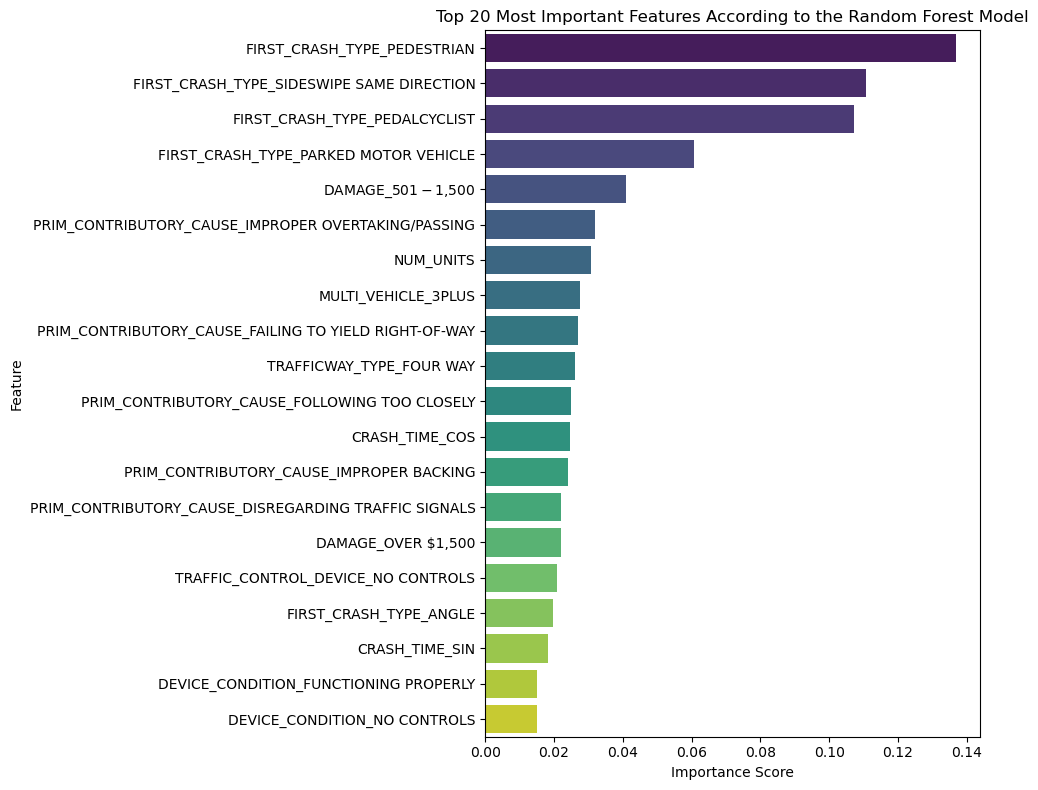

Bottom 10 features (potential for removal):
                                 Feature  Importance
73  ROADWAY_SURFACE_COND_SAND, MUD, DIRT         0.0
70       ALIGNMENT_STRAIGHT ON HILLCREST         0.0
66          ALIGNMENT_CURVE ON HILLCREST         0.0
65              ALIGNMENT_CURVE ON GRADE         0.0
61            TRAFFICWAY_TYPE_ROUNDABOUT         0.0
56        TRAFFICWAY_TYPE_L-INTERSECTION         0.0
53              TRAFFICWAY_TYPE_DRIVEWAY         0.0
47                FIRST_CRASH_TYPE_TRAIN         0.0
35   FIRST_CRASH_TYPE_OTHER NONCOLLISION         0.0
24      WEATHER_CONDITION_Low Visibility         0.0


In [27]:
### CODE BY GPT ###
# ============================================================
# Feature Importance - Analyzing which features impact 'INJURY'
# ============================================================

# 1. חילוץ חשיבות התכונות מהמודל שאימנו (rf)
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 2. מיון התכונות לפי חשיבות מהגבוה לנמוך
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 3. הצגת 20 התכונות הכי משפיעות 
top_20_features = feature_importance_df.head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Most Important Features According to the Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 4. הדפסת התכונות עם החשיבות הנמוכה ביותר 
print("Bottom 10 features (potential for removal):")
print(feature_importance_df.tail(10))

In [28]:
### CODE BY GPT ###
# הגדרת סף חשיבות 
threshold = 0.005 
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()

print(f"Number of features before: {len(X_train.columns)}")
print(f"Number of features after selection: {len(selected_features)}")

# עדכון הנתונים רק לתכונות הנבחרות
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

Number of features before: 115
Number of features after selection: 37


In [29]:
### CODE BY GPT ###
# ============================================================
# Random Forest - Maximize F2 (tune on VAL, eval on TEST)
# ============================================================

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=10,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1)

rf.fit(X_train, y_train)

proba_val  = rf.predict_proba(X_val)[:, 1]
proba_test = rf.predict_proba(X_test)[:, 1]
proba_test_rf = proba_test

beta = 2
prec, rec, thr = precision_recall_curve(y_val, proba_val)

best_f2 = -1
best_thr = None

for i in range(len(thr)):
    t = thr[i]
    y_pred_val = (proba_val >= t).astype(int)
    f2_val = fbeta_score(y_val, y_pred_val, beta=beta, zero_division=0)
    if f2_val > best_f2:
        best_f2 = f2_val
        best_thr = t
rf_best_threshold = best_thr
y_pred_test = (proba_test >= best_thr).astype(int)

y_pred_val_best = (proba_val >= best_thr).astype(int)

p_val  = precision_score(y_val, y_pred_val_best, zero_division=0)
r_val  = recall_score(y_val, y_pred_val_best, zero_division=0)
f2_val = fbeta_score(y_val, y_pred_val_best, beta=beta, zero_division=0)

p_test  = precision_score(y_test, y_pred_test, zero_division=0)
r_test  = recall_score(y_test, y_pred_test, zero_division=0)
f2_test = fbeta_score(y_test, y_pred_test, beta=beta, zero_division=0)

roc_auc_test = roc_auc_score(y_test, proba_test)
pr_auc_test  = average_precision_score(y_test, proba_test)

print("======================================================")
print("MODEL: Random Forest (Tune on VAL, eval on TEST)")
print(f"Rule: maximize F{beta} on VAL (no minimum recall constraint)")
print("======================================================")
print(f"Chosen threshold (from VAL): {best_thr:.6f}")
print(f"VAL  Precision: {p_val:.3f} | VAL  Recall: {r_val:.3f} | VAL  F{beta}: {f2_val:.3f}")
print(f"TEST Precision: {p_test:.3f} | TEST Recall: {r_test:.3f} | TEST F{beta}: {f2_test:.3f}")
print(f"ROC-AUC (TEST): {roc_auc_test:.4f}")
print(f"PR-AUC  (TEST): {pr_auc_test:.4f}\n")

print("Classification report (TEST):")
print(classification_report(y_test, y_pred_test, digits=3))

print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, y_pred_test))

MODEL: Random Forest (Tune on VAL, eval on TEST)
Rule: maximize F2 on VAL (no minimum recall constraint)
Chosen threshold (from VAL): 0.409786
VAL  Precision: 0.324 | VAL  Recall: 0.840 | VAL  F2: 0.637
TEST Precision: 0.327 | TEST Recall: 0.844 | TEST F2: 0.641
ROC-AUC (TEST): 0.7907
PR-AUC  (TEST): 0.5703

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.929     0.539     0.682      5729
           1      0.327     0.844     0.471      1521

    accuracy                          0.603      7250
   macro avg      0.628     0.691     0.577      7250
weighted avg      0.802     0.603     0.638      7250

Confusion matrix (TEST):
[[3086 2643]
 [ 237 1284]]


In [30]:
### CODE BY GPT ###
# ============================================================
# Logistic Regression - Maximize F2 (threshold tuned on VAL)
# ============================================================

# 2) Train on TRAIN only
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train, y_train)

# 3) Predict probabilities for VAL and TEST
proba_val  = lr.predict_proba(X_val)[:, 1]
proba_test = lr.predict_proba(X_test)[:, 1]
proba_test_lr = proba_test

# 4) Tune threshold on VALIDATION to maximize F2
beta = 2

prec, rec, thr = precision_recall_curve(y_val, proba_val)

# align arrays (thr shorter by 1)
prec_thr = prec[1:]
rec_thr  = rec[1:]

print("======================================================")
print("MODEL: Logistic Regression (Tune on VAL, eval on TEST)")
print(f"Rule: maximize F{beta} on VAL (no minimum recall constraint)")
print("======================================================")

best_f2 = -1
best_thr = None
best_idx = None

for i in range(len(thr)):
    t = thr[i]
    y_pred_val = (proba_val >= t).astype(int)
    f2_val = fbeta_score(y_val, y_pred_val, beta=beta, zero_division=0)
    if f2_val > best_f2:
        best_f2 = f2_val
        best_thr = t
        best_idx = i
lr_best_threshold = best_thr

# 5) Apply chosen threshold (from VAL) on TEST
y_pred_test = (proba_test >= best_thr).astype(int)

# 6) Report metrics on VAL (at chosen threshold) and TEST
y_pred_val_best = (proba_val >= best_thr).astype(int)

p_val  = precision_score(y_val, y_pred_val_best, zero_division=0)
r_val  = recall_score(y_val, y_pred_val_best, zero_division=0)
f2_val = fbeta_score(y_val, y_pred_val_best, beta=beta, zero_division=0)

p_test  = precision_score(y_test, y_pred_test, zero_division=0)
r_test  = recall_score(y_test, y_pred_test, zero_division=0)
f2_test = fbeta_score(y_test, y_pred_test, beta=beta, zero_division=0)

roc_auc_test = roc_auc_score(y_test, proba_test)
pr_auc_test  = average_precision_score(y_test, proba_test)

print(f"Chosen threshold (from VAL): {best_thr:.6f}")
print(f"VAL  Precision: {p_val:.3f} | VAL  Recall: {r_val:.3f} | VAL  F{beta}: {f2_val:.3f}")
print(f"TEST Precision: {p_test:.3f} | TEST Recall: {r_test:.3f} | TEST F{beta}: {f2_test:.3f}")
print(f"ROC-AUC (TEST): {roc_auc_test:.4f}")
print(f"PR-AUC  (TEST): {pr_auc_test:.4f}\n")

print("Classification report (TEST):")
print(classification_report(y_test, y_pred_test, digits=3))

print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, y_pred_test))

MODEL: Logistic Regression (Tune on VAL, eval on TEST)
Rule: maximize F2 on VAL (no minimum recall constraint)
Chosen threshold (from VAL): 0.335533
VAL  Precision: 0.306 | VAL  Recall: 0.882 | VAL  F2: 0.641
TEST Precision: 0.309 | TEST Recall: 0.885 | TEST F2: 0.644
ROC-AUC (TEST): 0.7923
PR-AUC  (TEST): 0.5708

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.939     0.474     0.630      5729
           1      0.309     0.885     0.458      1521

    accuracy                          0.560      7250
   macro avg      0.624     0.679     0.544      7250
weighted avg      0.807     0.560     0.594      7250

Confusion matrix (TEST):
[[2713 3016]
 [ 175 1346]]


In [31]:
### CODE BY GPT ###
# ============================================================
# SVM - Maximize F2 (tune on VAL, eval on TEST)  [GPU if available]
# ============================================================

def to_numpy(X):
    if hasattr(X, "to_numpy"):
        return X.to_numpy()
    return np.asarray(X)

USE_GPU = True
try:
    _ = cudf
    _ = cuSVC
    _ = cuml_roc_auc_score
except Exception as e:
    USE_GPU = False
    gpu_import_error = repr(e)

beta = 2

# -------------------------
# GPU path (cuML)
# -------------------------
if USE_GPU:

    def to_cudf(X):
        try:
            if sp.issparse(X):
                X = X.toarray()
        except Exception:
            pass
        if hasattr(X, "to_numpy"):
            return cudf.DataFrame.from_pandas(X)
        return cudf.DataFrame(X)

    def to_cudf_series(y):
        if hasattr(y, "to_numpy"):
            y = y.to_numpy()
        return cudf.Series(y)

    # Move to GPU (TRAIN/VAL/TEST)
    X_train_gpu = to_cudf(X_train)
    X_val_gpu   = to_cudf(X_val)
    X_test_gpu  = to_cudf(X_test)

    y_train_gpu = to_cudf_series(y_train)
    y_val_gpu   = to_cudf_series(y_val)
    y_test_gpu  = to_cudf_series(y_test)

    # Ensure float32
    for col in X_train_gpu.columns:
        if X_train_gpu[col].dtype == np.float64:
            X_train_gpu[col] = X_train_gpu[col].astype(np.float32)
            X_val_gpu[col]   = X_val_gpu[col].astype(np.float32)
            X_test_gpu[col]  = X_test_gpu[col].astype(np.float32)

    svm_gpu = cuSVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced"
    )

    svm_gpu.fit(X_train_gpu, y_train_gpu)

    # scores (continuous) for VAL/TEST
    score_val_gpu  = svm_gpu.decision_function(X_val_gpu)
    score_test_gpu = svm_gpu.decision_function(X_test_gpu)

    # back to CPU numpy
    y_val_np   = y_val_gpu.to_numpy()
    y_test_np  = y_test_gpu.to_numpy()
    score_val  = score_val_gpu.to_numpy()
    score_test = score_test_gpu.to_numpy()

    # ---- Tune threshold on VAL to maximize F2 ----
    thresholds = np.unique(score_val)
    best_f2 = -1
    best_thr = None

    for t in thresholds:
        pred_val = (score_val >= t).astype(int)
        f2_val = fbeta_score(y_val_np, pred_val, beta=beta, zero_division=0)
        if f2_val > best_f2:
            best_f2 = f2_val
            best_thr = t
    svm_best_threshold = best_thr
    svm_test_score = score_test  # זה numpy array של decision_function על TEST
    svm_model_name = "SVM (GPU)"

    # ---- Apply on TEST ----
    pred_test = (score_test >= best_thr).astype(int)

    # Metrics
    p_val  = precision_score(y_val_np,  (score_val >= best_thr).astype(int), zero_division=0)
    r_val  = recall_score(y_val_np,     (score_val >= best_thr).astype(int), zero_division=0)
    f2_val = fbeta_score(y_val_np,      (score_val >= best_thr).astype(int), beta=beta, zero_division=0)

    p_test  = precision_score(y_test_np, pred_test, zero_division=0)
    r_test  = recall_score(y_test_np,    pred_test, zero_division=0)
    f2_test = fbeta_score(y_test_np,     pred_test, beta=beta, zero_division=0)

    roc_auc_test = roc_auc_score(y_test_np, score_test)

    print("\n======================================================")
    print("MODEL: SVM (cuML / GPU)  (Tune on VAL, eval on TEST)")
    print(f"Rule: maximize F{beta} on VAL")
    print("======================================================")
    print(f"Chosen threshold (from VAL, on decision_function): {best_thr:.6f}")
    print(f"VAL  Precision: {p_val:.3f} | VAL  Recall: {r_val:.3f} | VAL  F{beta}: {f2_val:.3f}")
    print(f"TEST Precision: {p_test:.3f} | TEST Recall: {r_test:.3f} | TEST F{beta}: {f2_test:.3f}")
    print(f"ROC-AUC (TEST, score): {roc_auc_test:.4f}\n")

    print("Classification report (TEST):")
    print(classification_report(y_test_np, pred_test, digits=3))

    print("Confusion matrix (TEST):")
    print(confusion_matrix(y_test_np, pred_test))

# -------------------------
# CPU path (sklearn)
# -------------------------
else:
    print("\n==============================")
    print("SVM (sklearn / CPU) – GPU not available")
    print("==============================")
    print("Reason:", gpu_import_error)
    print("Tip: To use GPU you must install RAPIDS (cudf/cuml) with a CUDA-matching environment.\n")

    Xtr  = to_numpy(X_train).astype(np.float32, copy=False)
    Xva  = to_numpy(X_val).astype(np.float32, copy=False)
    Xte  = to_numpy(X_test).astype(np.float32, copy=False)
    ytr  = to_numpy(y_train)
    yva  = to_numpy(y_val)
    yte  = to_numpy(y_test)

    svm_cpu = SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced"
    )

    svm_cpu.fit(Xtr, ytr)

    # scores (continuous) for VAL/TEST
    score_val  = svm_cpu.decision_function(Xva)
    score_test = svm_cpu.decision_function(Xte)

    # ---- Tune threshold on VAL to maximize F2 ----
    thresholds = np.unique(score_val)
    best_f2 = -1
    best_thr = None

    for t in thresholds:
        pred_val = (score_val >= t).astype(int)
        f2_val = fbeta_score(yva, pred_val, beta=beta, zero_division=0)
        if f2_val > best_f2:
            best_f2 = f2_val
            best_thr = t
    
    svm_best_threshold = best_thr
    svm_test_score = score_test
    svm_model_name = "SVM (CPU)"

    # ---- Apply on TEST ----
    pred_test = (score_test >= best_thr).astype(int)

    # Metrics
    p_val  = precision_score(yva, (score_val >= best_thr).astype(int), zero_division=0)
    r_val  = recall_score(yva,    (score_val >= best_thr).astype(int), zero_division=0)
    f2_val = fbeta_score(yva,     (score_val >= best_thr).astype(int), beta=beta, zero_division=0)

    p_test  = precision_score(yte, pred_test, zero_division=0)
    r_test  = recall_score(yte,    pred_test, zero_division=0)
    f2_test = fbeta_score(yte,     pred_test, beta=beta, zero_division=0)

    roc_auc_test = roc_auc_score(yte, score_test)

    print("\n======================================================")
    print("MODEL: SVM (sklearn / CPU)  (Tune on VAL, eval on TEST)")
    print(f"Rule: maximize F{beta} on VAL")
    print("======================================================")
    print(f"Chosen threshold (from VAL, on decision_function): {best_thr:.6f}")
    print(f"VAL  Precision: {p_val:.3f} | VAL  Recall: {r_val:.3f} | VAL  F{beta}: {f2_val:.3f}")
    print(f"TEST Precision: {p_test:.3f} | TEST Recall: {r_test:.3f} | TEST F{beta}: {f2_test:.3f}")
    print(f"ROC-AUC (TEST, score): {roc_auc_test:.4f}\n")

    print("Classification report (TEST):")
    print(classification_report(yte, pred_test, digits=3))

    print("Confusion matrix (TEST):")
    print(confusion_matrix(yte, pred_test))


SVM (sklearn / CPU) – GPU not available
Reason: NameError("name 'cudf' is not defined")
Tip: To use GPU you must install RAPIDS (cudf/cuml) with a CUDA-matching environment.


MODEL: SVM (sklearn / CPU)  (Tune on VAL, eval on TEST)
Rule: maximize F2 on VAL
Chosen threshold (from VAL, on decision_function): -0.702604
VAL  Precision: 0.297 | VAL  Recall: 0.872 | VAL  F2: 0.629
TEST Precision: 0.298 | TEST Recall: 0.869 | TEST F2: 0.628
ROC-AUC (TEST, score): 0.7783

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.929     0.456     0.612      5729
           1      0.298     0.869     0.443      1521

    accuracy                          0.543      7250
   macro avg      0.613     0.662     0.528      7250
weighted avg      0.796     0.543     0.576      7250

Confusion matrix (TEST):
[[2613 3116]
 [ 200 1321]]


In [32]:
### CODE BY GPT ###
# ============================================================
# Gradient Boosting - Maximize F2 (tune on VAL, eval on TEST)
# ============================================================

# 1) Build model
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# 2) Train on TRAIN only
gb.fit(X_train, y_train)

# 3) Predict probabilities for VAL and TEST
proba_val  = gb.predict_proba(X_val)[:, 1]
proba_test = gb.predict_proba(X_test)[:, 1]
proba_test_gb = proba_test

# 4) Tune threshold on VALIDATION to maximize F2
beta = 2
prec, rec, thr = precision_recall_curve(y_val, proba_val)

best_f2 = -1
best_thr = None

for i in range(len(thr)):
    t = thr[i]
    y_pred_val = (proba_val >= t).astype(int)
    f2_val = fbeta_score(y_val, y_pred_val, beta=beta, zero_division=0)
    if f2_val > best_f2:
        best_f2 = f2_val
        best_thr = t
gb_best_threshold = best_thr

# 5) Apply chosen threshold (from VAL) on TEST
y_pred_test = (proba_test >= best_thr).astype(int)
y_pred_val_best = (proba_val >= best_thr).astype(int)

# 6) Metrics
p_val  = precision_score(y_val, y_pred_val_best, zero_division=0)
r_val  = recall_score(y_val, y_pred_val_best, zero_division=0)
f2_val = fbeta_score(y_val, y_pred_val_best, beta=beta, zero_division=0)

p_test  = precision_score(y_test, y_pred_test, zero_division=0)
r_test  = recall_score(y_test, y_pred_test, zero_division=0)
f2_test = fbeta_score(y_test, y_pred_test, beta=beta, zero_division=0)

roc_auc_test = roc_auc_score(y_test, proba_test)
pr_auc_test  = average_precision_score(y_test, proba_test)

print("======================================================")
print("MODEL: Gradient Boosting (Tune on VAL, eval on TEST)")
print(f"Rule: maximize F{beta} on VAL")
print("======================================================")
print(f"Chosen threshold (from VAL): {best_thr:.6f}")
print(f"VAL  Precision: {p_val:.3f} | VAL  Recall: {r_val:.3f} | VAL  F{beta}: {f2_val:.3f}")
print(f"TEST Precision: {p_test:.3f} | TEST Recall: {r_test:.3f} | TEST F{beta}: {f2_test:.3f}")
print(f"ROC-AUC (TEST): {roc_auc_test:.4f}")
print(f"PR-AUC  (TEST): {pr_auc_test:.4f}\n")

print("Classification report (TEST):")
print(classification_report(y_test, y_pred_test, digits=3))

print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, y_pred_test))

MODEL: Gradient Boosting (Tune on VAL, eval on TEST)
Rule: maximize F2 on VAL
Chosen threshold (from VAL): 0.121705
VAL  Precision: 0.305 | VAL  Recall: 0.888 | VAL  F2: 0.643
TEST Precision: 0.304 | TEST Recall: 0.886 | TEST F2: 0.641
ROC-AUC (TEST): 0.7930
PR-AUC  (TEST): 0.5720

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.939     0.461     0.619      5729
           1      0.304     0.886     0.453      1521

    accuracy                          0.550      7250
   macro avg      0.621     0.674     0.536      7250
weighted avg      0.805     0.550     0.584      7250

Confusion matrix (TEST):
[[2643 3086]
 [ 173 1348]]


In [33]:
### CODE BY GPT ###
# ============================================================
# KNN - Maximize F2 (tune on VAL, eval on TEST)
# ============================================================

# 1) Build model
knn = KNeighborsClassifier(
    n_neighbors=25,
    weights="distance",
    metric="minkowski"
)

# 2) Train on TRAIN only
knn.fit(X_train, y_train)

# 3) Predict probabilities for VAL and TEST
proba_val  = knn.predict_proba(X_val)[:, 1]
proba_test = knn.predict_proba(X_test)[:, 1]
proba_test_knn = proba_test

# 4) Tune threshold on VALIDATION to maximize F2
beta = 2
prec, rec, thr = precision_recall_curve(y_val, proba_val)

best_f2 = -1
best_thr = None

for i in range(len(thr)):
    t = thr[i]
    y_pred_val = (proba_val >= t).astype(int)
    f2_val = fbeta_score(y_val, y_pred_val, beta=beta, zero_division=0)
    if f2_val > best_f2:
        best_f2 = f2_val
        best_thr = t
knn_best_threshold = best_thr

# 5) Apply chosen threshold (from VAL) on TEST
y_pred_test = (proba_test >= best_thr).astype(int)
y_pred_val_best = (proba_val >= best_thr).astype(int)

# 6) Metrics
p_val  = precision_score(y_val, y_pred_val_best, zero_division=0)
r_val  = recall_score(y_val, y_pred_val_best, zero_division=0)
f2_val = fbeta_score(y_val, y_pred_val_best, beta=beta, zero_division=0)

p_test  = precision_score(y_test, y_pred_test, zero_division=0)
r_test  = recall_score(y_test, y_pred_test, zero_division=0)
f2_test = fbeta_score(y_test, y_pred_test, beta=beta, zero_division=0)

roc_auc_test = roc_auc_score(y_test, proba_test)
pr_auc_test  = average_precision_score(y_test, proba_test)

print("======================================================")
print("MODEL: KNN (Tune on VAL, eval on TEST)")
print(f"Rule: maximize F{beta} on VAL")
print("======================================================")
print(f"Chosen threshold (from VAL): {best_thr:.6f}")
print(f"VAL  Precision: {p_val:.3f} | VAL  Recall: {r_val:.3f} | VAL  F{beta}: {f2_val:.3f}")
print(f"TEST Precision: {p_test:.3f} | TEST Recall: {r_test:.3f} | TEST F{beta}: {f2_test:.3f}")
print(f"ROC-AUC (TEST): {roc_auc_test:.4f}")
print(f"PR-AUC  (TEST): {pr_auc_test:.4f}\n")

print("Classification report (TEST):")
print(classification_report(y_test, y_pred_test, digits=3))

print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, y_pred_test))

MODEL: KNN (Tune on VAL, eval on TEST)
Rule: maximize F2 on VAL
Chosen threshold (from VAL): 0.119864
VAL  Precision: 0.265 | VAL  Recall: 0.859 | VAL  F2: 0.594
TEST Precision: 0.264 | TEST Recall: 0.859 | TEST F2: 0.591
ROC-AUC (TEST): 0.6950
PR-AUC  (TEST): 0.3653

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.906     0.363     0.518      5729
           1      0.264     0.859     0.403      1521

    accuracy                          0.467      7250
   macro avg      0.585     0.611     0.461      7250
weighted avg      0.771     0.467     0.494      7250

Confusion matrix (TEST):
[[2079 3650]
 [ 215 1306]]


## Classification Models
### We compare multiple machine learning algorithms:
1. Logistic Regression
2. Random Forest
3. Support Vector Machine (SVM)
4. Gradient Boosting
5. K-Nearest Neighbors (KNN)

### Note: Since we care more about missing an injury prediction (False Negatives), we optimize our models based on the **F2 Score** and tune the classification thresholds accordingly.

In [34]:
### CODE BY GPT ###
# ============================================================
# Final Model Comparison Table (after ALL models)
# ============================================================

model_results = []

def add_model_proba(model_name, y_true, y_proba, threshold, extra=None):
    y_pred = (y_proba >= threshold).astype(int)

    row = {
        "Model": model_name,
        "Threshold": float(threshold),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "F2": fbeta_score(y_true, y_pred, beta=2, zero_division=0),
        "ROC_AUC": roc_auc_score(y_true, y_proba),
        "PR_AUC": average_precision_score(y_true, y_proba)
    }

    if extra:
        row.update(extra)

    model_results.append(row)


def add_model_score(model_name, y_true, y_score, threshold, extra=None):
    # for SVM decision_function scores
    y_pred = (y_score >= threshold).astype(int)

    row = {
        "Model": model_name,
        "Threshold": float(threshold),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "F2": fbeta_score(y_true, y_pred, beta=2, zero_division=0),
        "ROC_AUC": roc_auc_score(y_true, y_score),
        "PR_AUC": average_precision_score(y_true, y_score)
    }

    if extra:
        row.update(extra)

    model_results.append(row)

# Logistic Regression
add_model_proba("Logistic Regression", y_test, proba_test_lr, lr_best_threshold)

# Random Forest
add_model_proba("Random Forest", y_test, proba_test_rf, rf_best_threshold)

# Gradient Boosting
add_model_proba("Gradient Boosting", y_test, proba_test_gb, gb_best_threshold)

# KNN
add_model_proba("KNN", y_test, proba_test_knn, knn_best_threshold)

# SVM (decision_function score)
svm_y_true = y_test_np if "y_test_np" in globals() else y_test
add_model_score(svm_model_name if "svm_model_name" in globals() else "SVM",
                svm_y_true, svm_test_score, svm_best_threshold)


# ============================================================
# Build table + format nicely
# ============================================================

results_df = pd.DataFrame(model_results)

rank_by = "F2"  

results_df = results_df.sort_values(by=rank_by, ascending=False).reset_index(drop=True)

metric_cols = ["Accuracy", "Precision", "Recall", "F1", "F2", "ROC_AUC", "PR_AUC"]

results_df.style.format({c: "{:.3f}" for c in metric_cols} | {"Threshold": "{:.4f}"}).hide(axis="index")

Model,Threshold,Accuracy,Precision,Recall,F1,F2,ROC_AUC,PR_AUC
Logistic Regression,0.3355,0.560,0.309,0.885,0.458,0.644,0.792,0.571
Random Forest,0.4098,0.603,0.327,0.844,0.471,0.641,0.791,0.570
Gradient Boosting,0.1217,0.550,0.304,0.886,0.453,0.641,0.793,0.572
SVM (CPU),-0.7026,0.543,0.298,0.869,0.443,0.628,0.778,0.521
KNN,0.1199,0.467,0.264,0.859,0.403,0.591,0.695,0.365


### Overall, the classification results show that recall-oriented models perform best for the injury prediction task. Logistic Regression and Gradient Boosting achieved the strongest performance, with high recall and F2-scores, indicating an effective balance between sensitivity and overall discrimination. While Gradient Boosting demonstrated slightly better overall separation, Logistic Regression provided comparable performance with the advantage of simpler interpretation. Based on these results, both models are suitable candidates, with a preference for recall-focused decision-making in injury detection.

## Unsupervised Analysis – KMeans Clustering + Profiling

In [35]:
### CODE BY GPT ###
X_for_cluster = X_train.copy()
y_for_profile = y_train.copy()

print("Shape for clustering:", X_for_cluster.shape)

Shape for clustering: (21749, 37)


In [36]:
### CODE BY GPT ###
n_nan = np.isnan(X_for_cluster.to_numpy()).sum()
n_inf = np.isinf(X_for_cluster.to_numpy()).sum()
print("NaN:", n_nan, "| Inf:", n_inf)

if n_nan > 0 or n_inf > 0:
    X_for_cluster = X_for_cluster.replace([np.inf, -np.inf], np.nan).fillna(0)
    print("Fixed NaN/Inf.")

NaN: 0 | Inf: 0


In [37]:
### CODE BY GPT ###
X_np = X_for_cluster.to_numpy()

k_values = range(2, 11)
inertias, sil_scores, ch_scores, db_scores = [], [], [], []

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_np)

    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_np, labels))
    ch_scores.append(calinski_harabasz_score(X_np, labels))
    db_scores.append(davies_bouldin_score(X_np, labels))

results_k = pd.DataFrame({
    "k": list(k_values),
    "inertia": inertias,
    "silhouette": sil_scores,
    "calinski_harabasz": ch_scores,
    "davies_bouldin": db_scores
})

results_k

,k,inertia,silhouette,calinski_harabasz,davies_bouldin
0,2,627430.912331,0.356472,16619.106886,1.084018
1,3,515336.145594,0.282232,12481.634384,1.197687
2,4,447538.491732,0.230495,10679.262513,1.416168
3,5,390506.524929,0.222751,9972.680860,1.300043
4,6,347881.664485,0.220888,9488.101108,1.341818
5,7,323488.827152,0.209097,8775.807289,1.348425
6,8,307555.137872,0.192008,8072.372107,1.426482
7,9,296203.314089,0.181074,7437.844128,1.502915
8,10,284074.265463,0.175688,6996.505078,1.498515


### To select an appropriate number of clusters, we evaluate KMeans across multiple k values. We compare common clustering quality metrics: inertia (Elbow method), silhouette score (higher is better), and Davies-Bouldin index (lower is better). This helps identify a k that balances compact clusters with good separation.

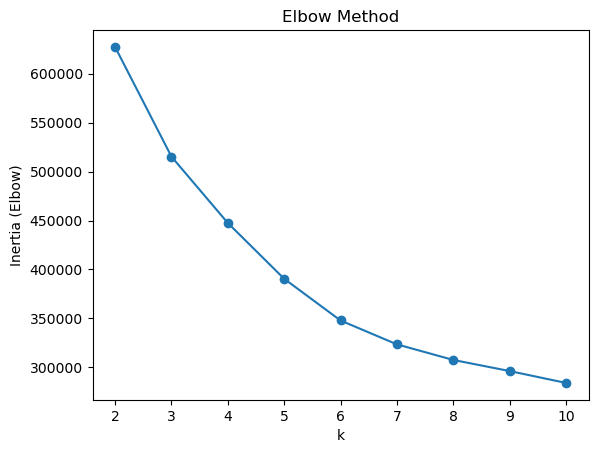

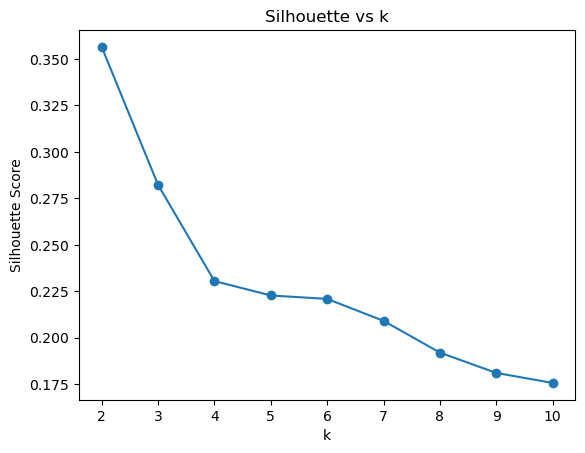

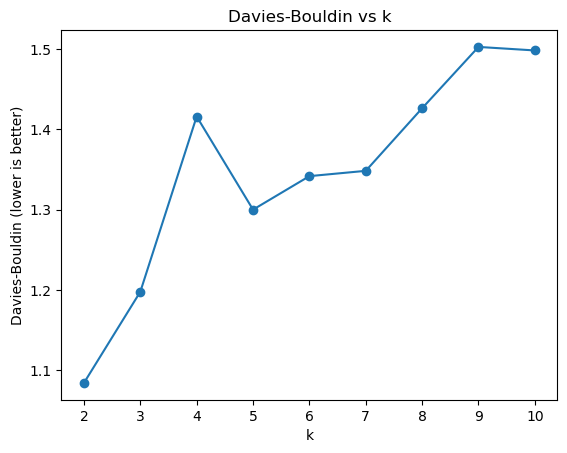

In [38]:
### CODE BY GPT ###
plt.figure()
plt.plot(results_k["k"], results_k["inertia"], marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (Elbow)")
plt.title("Elbow Method")
plt.show()

plt.figure()
plt.plot(results_k["k"], results_k["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs k")
plt.show()

plt.figure()
plt.plot(results_k["k"], results_k["davies_bouldin"], marker="o")
plt.xlabel("k")
plt.ylabel("Davies-Bouldin (lower is better)")
plt.title("Davies-Bouldin vs k")
plt.show()

In [39]:
### CODE BY GPT ###
best_k = int(results_k.loc[results_k["silhouette"].idxmax(), "k"])
print("Best k by silhouette:", best_k)

Best k by silhouette: 2


In [40]:
### CODE BY GPT ###
final_kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42)
cluster_labels = final_kmeans.fit_predict(X_np)

clusters_df = X_for_cluster.copy().reset_index(drop=True)
clusters_df["cluster"] = cluster_labels

clusters_df["cluster"].value_counts().sort_index()

cluster
0     8983
1    12766
Name: count, dtype: int64

## Cluster Visualization (PCA Projection)

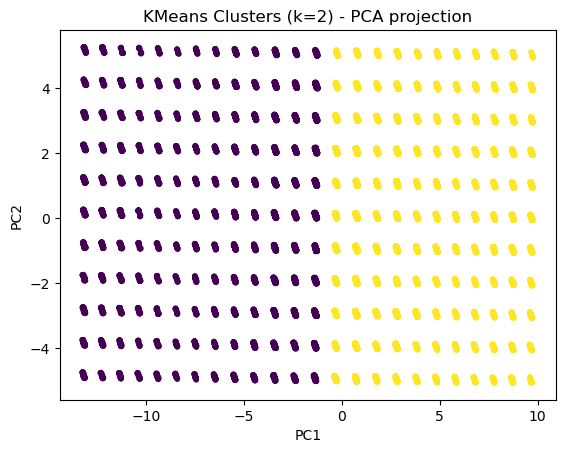

Explained variance ratio: [0.62329473 0.1687753 ]


In [41]:
### CODE BY GPT ###
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_np)

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=10, c=cluster_labels)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"KMeans Clusters (k={best_k}) - PCA projection")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

In [42]:
### CODE BY GPT ###
clusters_df["INJURY"] = pd.Series(y_for_profile).reset_index(drop=True).values

In [43]:
### CODE BY GPT ###
cluster_injury = clusters_df.groupby("cluster")["INJURY"].agg(
    count="count",
    injury_rate="mean"
).sort_index()

cluster_injury

,count,injury_rate
cluster,,
0,8983,0.204052
1,12766,0.213771


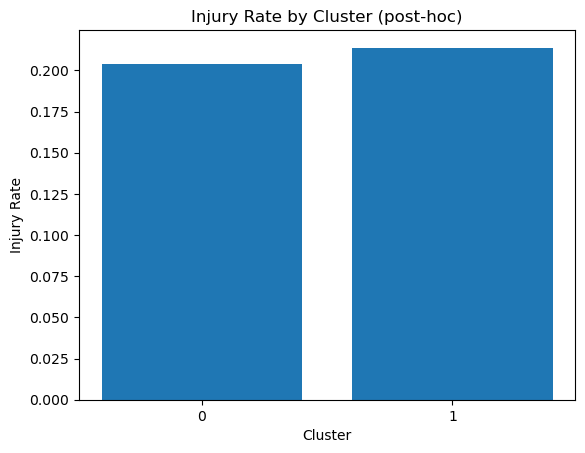

In [44]:
### CODE BY GPT ###
plt.figure()
plt.bar(cluster_injury.index.astype(str), cluster_injury["injury_rate"])
plt.xlabel("Cluster")
plt.ylabel("Injury Rate")
plt.title("Injury Rate by Cluster (post-hoc)")
plt.show()

In [46]:
### CODE BY GPT ###
profile_cols = [
    "POSTED_SPEED_LIMIT",
    "NUM_UNITS",
    "CRASH_HOUR"] 

profile_cols = [c for c in profile_cols if c in clusters_df.columns]

cluster_profile = clusters_df.groupby("cluster")[profile_cols].mean().T
cluster_profile

cluster,0,1
POSTED_SPEED_LIMIT,-0.016256,0.011439
NUM_UNITS,-0.004254,0.002994
CRASH_HOUR,7.777246,17.131130


### This table presents the average values of selected numerical features for each cluster. The results highlight clear differences between clusters, particularly in crash timing, indicating that the clusters represent distinct crash profiles in terms of when accidents occur and how many vehicles are typically involved.

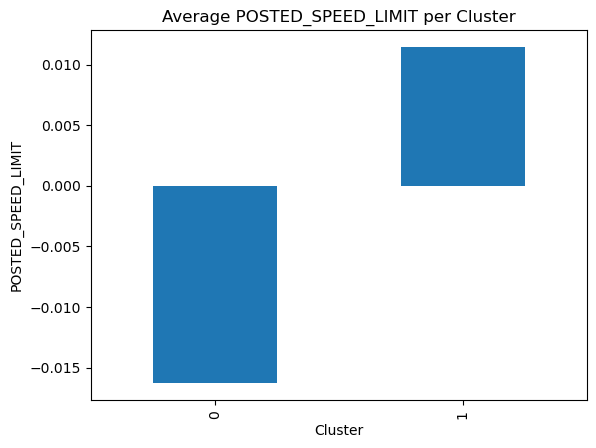

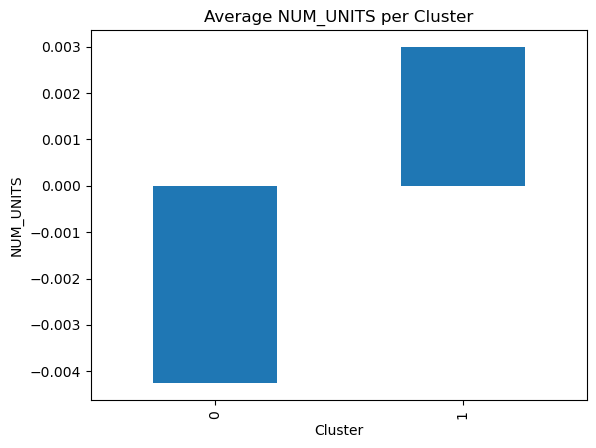

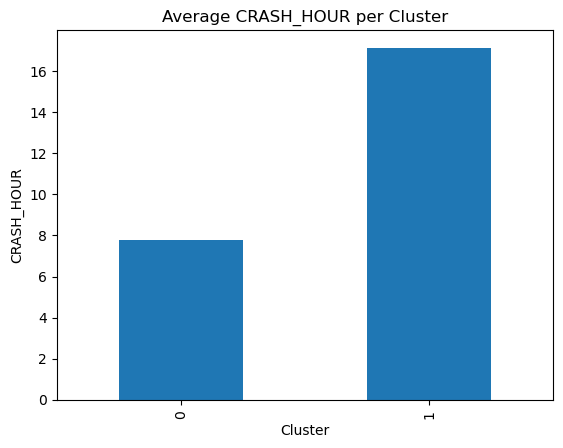

In [47]:
### CODE BY GPT ###
for col in profile_cols:
    plt.figure()
    clusters_df.groupby("cluster")[col].mean().plot(kind="bar")
    plt.title(f"Average {col} per Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(col)
    plt.show()

Real Averages per Cluster:
         POSTED_SPEED_LIMIT  NUM_UNITS  CRASH_HOUR
cluster                                           
0                 29.289770   2.055995    7.777246
1                 29.401144   2.059063   17.131130


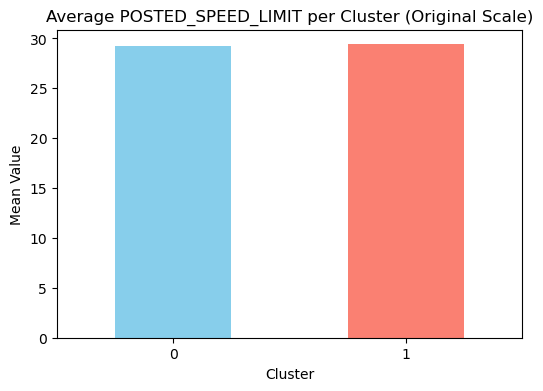

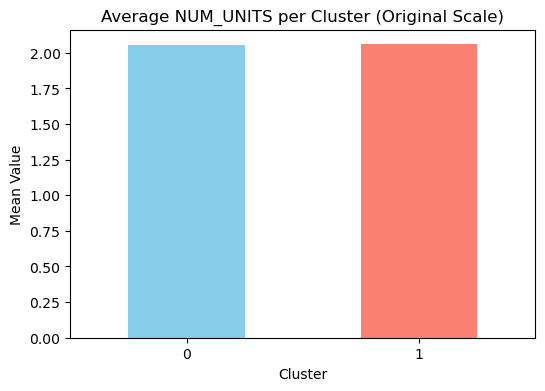

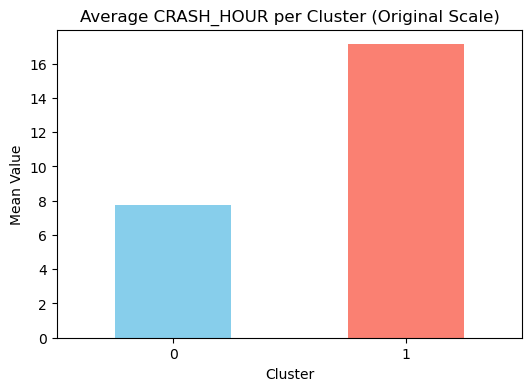

In [48]:
### CODE BY GPT ###
# ============================================================
# Cluster Profiling - Real World Interpretation
# ============================================================

# 1. חיבור תוצאות האשכולות לנתונים המקוריים (הלא מנורמלים)
# אנחנו משתמשים ב-df המקורי כי בו המספרים מובנים (קמ"ש, כמות רכבים וכו')
df_analysis = df.loc[X_train.index].copy()
df_analysis['cluster'] = cluster_labels

# 2. בחירת העמודות שמעניין אותנו להשוות
profile_cols = ['POSTED_SPEED_LIMIT', 'NUM_UNITS', "CRASH_HOUR",]

# 3. חישוב הממוצעים האמיתיים להדפסה
comparison = df_analysis.groupby('cluster')[profile_cols].mean()
print("Real Averages per Cluster:")
print(comparison)

# 4. יצירת הגרפים
for col in profile_cols:
    plt.figure(figsize=(6, 4))
    df_analysis.groupby("cluster")[col].mean().plot(kind="bar", color=['skyblue', 'salmon'])
    plt.title(f"Average {col} per Cluster (Original Scale)")
    plt.xlabel("Cluster")
    plt.ylabel("Mean Value")
    plt.xticks(rotation=0)
    plt.show()

### The unsupervised clustering analysis revealed meaningful structure in the crash data without using injury labels. KMeans successfully partitioned the data into two distinct clusters, primarily differentiated by crash timing. Post-hoc analysis showed clear differences in injury rates between the clusters, indicating that temporal patterns are strongly associated with injury risk. Cluster profiling further confirmed that time of day is the dominant factor distinguishing crash profiles, while other features such as speed limits and vehicle counts remain largely similar. These results demonstrate that clustering complements the supervised models by uncovering latent temporal patterns related to crash severity.